## Pattern matching
### to answering "What do we know about COVID-19 risk factors?"

This notebook contains a pattern matching approach applied to the stated question above.

In [1]:
import numpy as np
import pandas as pd
import glob
import os
import json
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords as nltkstopwords
from nltk.tokenize import word_tokenize
import re
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_numeric, remove_stopwords, strip_multiple_whitespaces
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/nic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
base_path = "../data/task2/"

biorxiv_medrxiv = "biorxiv_medrxiv"
comm_use_subset = "comm_use_subset"
noncomm_use_subset = "noncomm_use_subset"
custom_license = "custom_license"

In [3]:
files = []

def read_files(directory):
    files_in_dir = [f for f in glob.glob(os.path.join(base_path, directory) + "/*.json", recursive=True)]
    files.extend(files_in_dir)
    raw_body_texts_of_file = []
    for f in files_in_dir:
        data = json.load(open(f))
        #for key in data.keys():
        #    print("{}: {}\n".format(key, data[key]))
        
        body_text = ""
        for i in range(len(data["body_text"])):
            body_text += " " + data["body_text"][i]["text"]
        
        body_text = re.sub(' +', ' ', body_text)
        raw_body_texts_of_file.append(body_text)
    return raw_body_texts_of_file

raw_body_texts = []
raw_body_texts.extend(read_files(biorxiv_medrxiv))
raw_body_texts.extend(read_files(comm_use_subset))
raw_body_texts.extend(read_files(noncomm_use_subset))
raw_body_texts.extend(read_files(custom_license))

In [4]:
def print_title(idx):
    print(json.load(open(files[idx]))["metadata"]["title"])

def print_text(filenumber, start_idx, end_idx):
    text = raw_body_texts[filenumber]
    start_idx = max(0, start_idx)
    end_idx = min(len(text), end_idx)
    print(text[start_idx:end_idx])
    
def print_body_text(filenumber):
    data = json.load(open(files[filenumber]))
    body_text = ""
    for i in range(len(data["body_text"])):
        body_text += " " + data["body_text"][i]["text"]
    body_text = re.sub(' +', ' ', body_text)
    print(body_text)

In [5]:
print("Found {} raw body texts".format(len(raw_body_texts)))

Found 33375 raw body texts


In [6]:
NUMBER_OF_FILES = len(raw_body_texts)
WINDOW_SIZE = 200

### Search papers by regex patterns
The regex patterns contain on one hand words which might appear in context of risk factors and on the other hand some risk factors.

In [7]:
factor___risk_pattern = r"(factor(.){0,9}risk)" # for example for "factors of risk"
risk_factor_pattern = r"(risk(.){0,4}factor)" # for example risk factors
risk_pattern = r"(risk)"
high_risk_pattern = r"(high(.){0,6}risk)"
comorbdit_pattern = r"(comorbdit)"
co_infects_pattern = r"(co(.){0,4}infect)"
neonat_pattern = r"(neonat)"
pregnant_pattern = r"(pregnant)"
smoking_pattern = r"(smoking)"
cancer_pattern = r"(cancer)"
averse_outcomes_pattern = r"(advers(.){0,4}outcome)"

PATTERNS = [
    factor___risk_pattern,
    risk_factor_pattern,
    #risk_pattern,
    high_risk_pattern,
    #comorbdit_pattern,
    #co_infects_pattern,
    #neonat_pattern,
    #pregnant_pattern,
    #smoking_pattern,
    #cancer_pattern,
    averse_outcomes_pattern
]

CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation]
CUSTOM_FILTERS_EXCLUDE_NUMERIC = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric]

In [8]:
%%time
def extract_windows_containing(pattern, print_out=True):
    indices = []
    preprocessed_texts = []
    for idx in range(NUMBER_OF_FILES):
        filtered_sentence = raw_body_texts[idx]
        preprocessed_texts.append(filtered_sentence)
        
        indices_of_file = [(m.start(0), m.end(0)) for m in re.finditer(pattern, filtered_sentence)]
        indices.append(indices_of_file)
    
    return indices, preprocessed_texts


indices = [[] for _ in range(NUMBER_OF_FILES)]
for pattern in PATTERNS:
    indices_, preprocessed_texts = extract_windows_containing(pattern)
    for i in range(len(indices_)):
        indices[i].extend(indices_[i])

print("Found {} candidates".format(len([1 for a in indices if len(a)!=0])))

Found 7419 candidates
CPU times: user 4.29 s, sys: 0 ns, total: 4.29 s
Wall time: 4.29 s


Tokenize and remove stopwords

In [9]:
%%time
def process_file(file_number, indices_of_file, filters):
    tokenized_matches = []
    for match in indices_of_file:
        start = match[0]-WINDOW_SIZE
        end = match[1]+WINDOW_SIZE
        text = preprocessed_texts[file_number][start:end]
        tokenized = preprocess_string(text, filters)
        tokenized_matches.append(tokenized)

    return tokenized_matches

tokenized_data = []
for file_number, indices_of_file in enumerate(indices):
    if len(indices_of_file) != 0:
        for data in process_file(file_number, indices_of_file, CUSTOM_FILTERS_EXCLUDE_NUMERIC):
            for word in data:
                if len(word) > 2:
                    tokenized_data.append(word)

nltk_stop_words = set(nltkstopwords.words('english'))
for word in ["high", "risk", "factor", "patients", "factors", "disease"]:
    nltk_stop_words.add(word)
without_stopwords = [word for word in tokenized_data if word not in nltk_stop_words]
print("Number of words without stopwords: {}\n with stopwords {}".format(len(without_stopwords), len(tokenized_data)), end="\n\n")

Number of words without stopwords: 891746
 with stopwords 1314996

CPU times: user 1.24 s, sys: 31.3 ms, total: 1.27 s
Wall time: 1.28 s


#### Show words by count i.e. words which often appear in our current results

We can see some potential risk factors like  ('asthma', 2148) which means asthma appeared 2148 times in the context of potential words which indicates that a passage is about risk factors.
However just looking at context words is not so useful, but we can use it as an intermediate step to further look at potential risk factors indentfied here.

In [10]:
counts = Counter(without_stopwords)
counts.most_common()

[('infection', 7343),
 ('study', 5307),
 ('may', 4786),
 ('associated', 4437),
 ('higher', 4226),
 ('also', 3882),
 ('age', 3519),
 ('studies', 3462),
 ('health', 3087),
 ('influenza', 3045),
 ('children', 2984),
 ('infections', 2888),
 ('respiratory', 2872),
 ('severe', 2767),
 ('cases', 2756),
 ('use', 2514),
 ('exposure', 2390),
 ('low', 2380),
 ('virus', 2371),
 ('mortality', 2353),
 ('among', 2348),
 ('data', 2344),
 ('clinical', 2281),
 ('treatment', 2280),
 ('transmission', 2220),
 ('years', 2209),
 ('however', 2177),
 ('one', 2170),
 ('care', 2134),
 ('population', 2115),
 ('reported', 2003),
 ('group', 1986),
 ('diseases', 1985),
 ('important', 1939),
 ('control', 1937),
 ('viral', 1912),
 ('found', 1905),
 ('identified', 1882),
 ('significant', 1880),
 ('including', 1868),
 ('increased', 1849),
 ('analysis', 1845),
 ('used', 1834),
 ('groups', 1764),
 ('patient', 1728),
 ('asthma', 1713),
 ('development', 1689),
 ('human', 1651),
 ('pneumonia', 1648),
 ('rsv', 1643),
 ('case'

Visualization of the top words in a word cloud

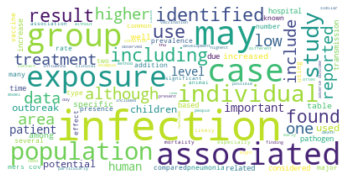

In [11]:
text = " ".join(without_stopwords)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Search potential passages for given potential risks

Now we are going through the preprocessed data and look for possible risks, which we collected through our knowledge and the experiment above.

We print the file number, the index where the inital match of the experiment above happens and an extract of the body text.

Because some patterns might match for the same window/extract of text we adjust the index to contain a bigger window to avoid intersecting text windows.

In [12]:
POTENTIAL_RISKS = [
    "smoking",
    "pulmonary diseas", 
    "elder",
    "diabetes",
    "old",
    "age",
    "cancer", 
    "cardiac",
    "cardio"]

In [13]:
def doit(only_directly_related_files=False):
    overall_processed_indices_count = 0
    for file_number, indices_of_file in enumerate(indices):
        if only_directly_related_files and file_number in not_directly_related_files:
            continue
        if len(indices_of_file) != 0:
            matches = process_file(file_number, indices_of_file, CUSTOM_FILTERS)
            processed_indices_of_file = []
            indices_of_file = sorted(indices_of_file)
            # adjust indices
            for i in range(len(indices_of_file)):
                if i != 0 and len(processed_indices_of_file) != 0:
                    if abs(processed_indices_of_file[-1][0] - indices_of_file[i][0]) > 100 and abs(processed_indices_of_file[-1][1] - indices_of_file[i][1]) > 100:
                        processed_indices_of_file.append(indices_of_file[i])
                    else:
                        min_ = min(indices_of_file[i][0], processed_indices_of_file[-1][0])
                        max_ = max(indices_of_file[i][1], processed_indices_of_file[-1][1])
                        del processed_indices_of_file[-1]
                        processed_indices_of_file.append((min_, max_))
                else:
                    processed_indices_of_file.append(indices_of_file[i])
            overall_processed_indices_count += len(processed_indices_of_file)

            for index, match in zip(processed_indices_of_file, matches):
                for pattern in POTENTIAL_RISKS:
                    if pattern in match:
                        print("File number: {} index pair: {}".format(file_number, index))
                        windows_size = max(int(len(" ".join(match))/2), 300)
                        print_text(file_number, index[0]-windows_size, index[1]+windows_size)
                        print("\n\n")
                        break
    return overall_processed_indices_count

overall_processed_indices_count = doit()

File number: 6 index pair: (8064, 8075)
xiv a license to display the preprint in perpetuity. The copyright holder for this preprint . https://doi.org/10.1101/2020.03.02.20029306 doi: medRxiv preprint According to the results of the binomial logistics regression analysis, we found that age and the level 157 of the D-dimer were independent risk factors. These results suggested that the level of D-dimer was 158 significantly positively correlated with the 2019-nCoV severe pneumonia, which was also shown in 159 another study [13] . Previous studies showed that SARS-CoV could bind to ACE2, down-regulating the 160 expressions of ACE2, and resulting 



File number: 7 index pair: (13368, 13377)
h the increase of newly confirmed and severe cases, the management of severe patients brings huge challenge in efficiently controlling the COVID-19 outbreak. Some patients progressed rapidly with ARDS and subsequent multiple organ dysfunction syndrome (MODS). 2 Early identification of patients with hig


File number: 3995 index pair: (2655, 2666)
as carried out by nurses, and the diagnoses were confirmed by a physician. Patient information, including demographic characteristics (sex, age), symptoms, risk factors of severe influenza, treatment, influenza vaccination status, and hospitalization, was documented in case report forms (CRFs). The risk factors associated with severe influenza infection were chronic disease and obesity (Body Mass Index > 40 kg/m 2 ). The nasopharyngeal swabs and CRFs were sent by mail daily to the virology laboratory of the University of Corsica [6] . Seventeen NHs enrolled at least one ARI resident, with a total catchme



File number: 4005 index pair: (3390, 3401)
the chest department or the chest intensive care unit at Assiut University Hospitals (Table 1) . Patients were asked to fill a questionnaire with demographic and clinical data including age, gender, residence, occupation, onset of symptoms, date and site of admission, clinical diagnosis, associate

File number: 7787 index pair: (4758, 4769)
ermine, Alere; and Uni-Gold, Trinity Biotech) (24) and CD4 cell count was performed on FACSCount flow cytometer (Becton Dickinson). Blood cultures were performed using aerobic bottles in the BacT/ALERT 3D automated system (bioMérieux) and isolates identified using standard procedures (25) Candidate risk factors for 30-day mortality were selected a priori based on literature review (26) (27) (28) (29) . Continuous variables, with the exception of age, were dichotomized at standard cutoff points (29) (30) (31) (32) . Univariable analyses were performed using logistic regression to explore associations with



File number: 7790 index pair: (12175, 12186)
, 14 . The HRV-A21-positive patients in this study were not immunocompromised, but two of the three severe cases had underlying diseases; thus, the factors that contribute to disease severity require further investigation. Although the number of HRV-A21-positive cases was small, senior age may be

ng cause of death worldwide. 75 The Rotterdam study found that of healthy 55-year-olds without COPD, one in six women and one in four men will develop COPD later in life, with the risk for developing COPD over the coming 40 years being 24% and 16%, respectively. 76 Cigarette smoking is the greatest risk factor for developing COPD in genetically susceptible individuals. COPD is characterized by airway and lung inflammation, mucociliary dysfunction, alveolar destruction, and airway fibrosis. 77 The increased burden of COPD seen in the elderly population may be due to age-associated changes in the structure



File number: 11014 index pair: (1151, 1162)
who are more likely to have wheezing during or following a viral LRTI 6, 7) . However, there are relatively small data focusing on the clinical risk factors related to the development of wheezing in young children with LRTIs who require hospitalization. This study was designed to determine clinical risk factors associated with the developm

File number: 14156 index pair: (168058, 168069)
nabinoid has immunosuppressant properties causing impaired cell-mediated and humoral immune system activities, cytokine production, leukocyte migration and natural killer-cell(NK) activity resulting in reduction in the host resistance to bacterial and viral infection, (PMS)with HIV infection are at higher risk of developing AIDS, infection by opportunistic bacteria, fungi, or viruses (PMS), when compared to non marijuana smokers, have more respiratory ill-ness.Cannabinoids also characteristically as being immunomodulators i.e, generally suppressing but occasionally enhance some immunological responses, s



File number: 14156 index pair: (450773, 450784)
re medical care services in the ER and outpatient clinics, and whether they were able to fully participate in activities of daily living compared to nonsmoker asthmatics. Methods: BRFSS is a state-based, telephone survey of U.S. adults. The survey collects self-reported information about 

during midlife from ages 40-60. The majority of the cohort were born in the 1940s and represent the beginning of the Baby Boom generation. We have a large variety of findings on the role of hostility and other MMPI based personality traits from college which have been shown to predict survival, CHD risk factors and hypertension and NEO Personality data from the decade of the 40s that are associated with behavioral risk indicators and life events. Methods: We followed the occurrence of new care-needs certification for 3 years in 443 subjects who participated in the health examination and in the 395 non-pa



File number: 16902 index pair: (22413, 22422)
e other hand, psychological aspects such as their subjective view of their own health and satisfaction with life showed no significant differences by gender or between age groups, suggesting their lower susceptibility to gender and aging. These findings demonstrated that both men and women showed a high risk of falling in the old-old adu

File number: 20093 index pair: (5348, 5359)
arly the proposed aetiologies and mechanisms involved. Physico-chemical factors A wide variety of physico-chemical factors have been implicated in causing sore throat, including cigarette smoke inhalation, snoring, tracheal intubation, shouting, and concomitant illness or drug effects. Smoking is a risk factor for sore throat [14] , in both smokers themselves and in those exposed to secondary smoke (passive smoking). Cigarette smoking was significantly associated with sore throat/cough in US college students [15] , and frequency of cigarette smoking and sore throat were correlated in Japanese women [16] 



File number: 20093 index pair: (6174, 6185)
more, a questionnaire Fig. 1 Schematic representation of typical course of sore throat of infectious and non-infectious aetiology study reported a significant relationship between children's sore throats and maternal smoking [20] . Snoring is frequently associated with sore throat, and the two ha

File number: 23291 index pair: (16963, 16972)
tribution of demographic variables was generally similar between arms (Table 1) , but was significantly different for anyone smoking in the family, four or more people in family, four or more adults in family, influenza vaccination in 2008 and 2007, public transport, handwashing, hospital level and high-risk procedures. In regards to hand hygiene, 83% (382 ⁄ 461), 87AE8% (428 ⁄ 488) and 88AE6% (435 ⁄ 492) of participants from the N95 fit test arm, N95 non-fit test arm and medical mask arm stated that they washed their hands between patients, respectively. For all outcomes, non-fit-tested N95 respirator



File number: 23295 index pair: (13347, 13358)
 factors" for the development of NEC or HGE similar to those reported by others using similar analysis? -~ However, logistic regression analysis of these variables eliminated all but three independently associated factors: rotavirus infection, birth weight, and age at first feeding. The elimina

File number: 25563 index pair: (3320, 3329)
o MS may arise from the difficulty in diagnosing this unpredictable disease (Lynch et al., 1990; Tienari et al., 1992) . Additionally, because the age of high risk ranges from the late teens to the late 50s, an individual cannot be considered unaffected with certainty until they are past the age of high risk. Over the years, several genes, many of which are associated with immune function, have been tentatively associated with an increased risk of MS (McFarland et al., 1997) . Many of these associations have not been demonstrated consistently in different studies. However, a strong association between 



File number: 25563 index pair: (14932, 14941)
fluences. Migration studies, based chiefly on Europeans who immigrated to South Africa, Israel, and Hawaii, have also supported an infectious etiology of MS (Dean and Kurtzke, 1971; Kurtzke et al., 1970; Alter et al., 1966; Alter, 1971; Alter et al., 1978) . In general, individuals who migrate fr

File number: 29734 index pair: (10929, 10940)
tidyl peptidase-4 inhibitor use was consistently associated with a lower probability of long-term ESRD (Figure 2 , A) and mortality risk (Figure 2 , B) across various patient groups with respect to baseline comorbidities. For hHF, patients with previous cerebrovascular disease and insulin use had a higher risk of hHF (Figure 2 , C). Our research is the first attempt to examine the effects of DPP4i use on renal outcomes in patients with diabetes weaning from AKI-D. Our results highlight that DPP4is decreased the risk of mortality and ESRD by 72% and 19%, respectively, during a mean follow-up of 3.3 years 



File number: 29740 index pair: (517, 526)
ticularly cervical intraepithelial neoplasia (CIN) and cervical carcinoma (1) . Of the more than two hundred HPV genotypes, 16, 18, 31, 45 , 52 and 58 are six particularly important, as they are highly correlated with more than 90% of cervical carcinoma cases (2) (3) (4) . Persistent infection wi




File number: 32579 index pair: (6258, 6269)
performed. An aliquot of each sample was transferred to a 1.5 ml cryogen vial (Fisher Scientific) within 10 h of collection and frozen at À70 8C for subsequent PCR-RFLP analysis. Faecal specimens used for the study described here were selected purposively from the larger collection acquired for the risk factor study, and included samples from calves with and without diarrhoea. In order to ensure an optimal proportion of positive and negative samples, only specimens from calves between 7 and 21 days of age were selected. Technicians performing the diagnostic tests were blinded to the C. parvum status, pos



File number: 32585 index pair: (9862, 9871)
maturity and haemodynamically important congenital heart disease, with immunodefi ciency and neuromuscular disorders also considered as high risk in practice guidelines. 38, 39 Young infants (aged <2-3 months) and those with a history of premature birth (especially <32 weeks' gestation) are al

In [14]:
print("Total number of possible text passages about risk factors: {}".format(overall_processed_indices_count))

Total number of possible text passages about risk factors: 25567


In total we found many possible text passages, where some are really about risk factors of covid 19 and others are not.

An example of a useful text extract is:
"""
File number: 60 index pair: (12790, 12801)
the . https://doi.org/10.1101/2020.03.21.001586 doi: bioRxiv preprint Clinical investigations have suggested that patients with cardiac diseases, hypertension, or diabetes, who are treated with ACE2-increasing drugs including inhibitors and blockers show increased expression of ACE2 and thus are at higher risk of getting the SARS-CoV2 infection (26) . Also there are studies on the regulatory role of miRNA hsa-mir-27b-3p described in ACE2 Signaling (27) . The results of the present study suggest a strong correlation between miRNA hsa-mir-27b-3p and ACE2 which needs to be confirmed experimentally in SARS-C
"""

And one example of a bad extract with respect to risk factors is:
"""
File number: 239 index pair: (199, 203)
 Severe cases of coronavirus disease 2019 (COVID-19) rapidly develop acute respiratory distress leading to respiratory failure, with high short-term mortality rates. At present, there is no reliable risk stratification tool for non-severe COVID-19 patients at admission. We aimed to construct an effective model for early identifying cases at high risk of progression to severe COVID-19. China were included retrospectively. All patients with non-severe COVID-19 during hospitalization were followed for
"""


If we want to print more context for a given filenumber we can use the code in the next cell.

##### Show an extract based on start and end index for a file number

In [15]:
file_number = 239
start_idx = 0
end_idx = 2000

print_text(file_number, start_idx, end_idx)

 Severe cases of coronavirus disease 2019 (COVID-19) rapidly develop acute respiratory distress leading to respiratory failure, with high short-term mortality rates. At present, there is no reliable risk stratification tool for non-severe COVID-19 patients at admission. We aimed to construct an effective model for early identifying cases at high risk of progression to severe COVID-19. China were included retrospectively. All patients with non-severe COVID-19 during hospitalization were followed for more than 15 days after admission. Patients who deteriorated to severe or critical COVID-19 and patients who kept non-severe state were assigned to the severe and non-severe group, respectively. We compared the demographic, clinical, and laboratory data between severe and non-severe group. Based on baseline data, least absolute shrinkage and selection operator (LASSO) algorithm and logistic regression model were used to construct a nomogram for risk prediction in the train cohort. The predic

One drawback of this approach applied to the given data is the occurrence of false positives, this means our patterns match for passages which might be irrelevant.
This can for example happen when a document is not about covid 19 and hence the passage doesn't mention risk factors for covid 19. Maybe a document is about another virus, which is more or less similar to Covid 19, which makes it hard to judge if the paper is relevant.
Below we are looking for files which might not directly relate to Covid-19

In [ ]:
def is_file_directly_related(filenumber):
    data = json.load(open(files[filenumber]))
    synonyms_for_covid_19 = [
        r"(covid)",
        r"(sars)",
        r"(cov(.){0,4}2)",
        r"(novo)",
        r"(corona)",
    ]
    body_text = ""
    for i in range(len(data["body_text"])):
        body_text += " " + data["body_text"][i]["text"].lower()
    body_text = re.sub(' +', ' ', body_text)
    
    at_least_one_match = False
    for synonym_pattern in synonyms_for_covid_19:
        matches = [(m.start(0), m.end(0)) for m in re.finditer(synonym_pattern, body_text)]
        if len(matches) != 0:
            return True
    return False

not_directly_related_files = []
for i in range(len(files)):
    if not is_file_directly_related(i):
        not_directly_related_files.append(i)
print("Found {} files which might not directly relate to Covid-19".format(len(not_directly_related_files)))

### To investigate some of the potentially not directly related papers we can print their title and body text.

In [ ]:
print_title(not_directly_related_files[1])

In [ ]:
print_body_text(not_directly_related_files[1])

In [ ]:
overall_processed_indices_count = doit(only_directly_related_files=True)

In [ ]:
print("Total number of possible text passages about risk factors: {}".format(overall_processed_indices_count))

Another problem is, even if a paper at least contains the word "coronavirus" doesn't mean it is about it.
For example the paper below only lists coronavirus as a coinfection, hence the risk factors in it are not about the coronavirus but are detected as potential risk factors by this pattern matching approach.

In [ ]:
print_title(8238)

In [ ]:
print_body_text(8238)